### Test MiniGrid FlatObsWrapper with stable-baselines3

Import libraries

In [1]:
# Imports
import time
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper

/Users/inigo/.local/share/virtualenvs/tfm-experiments-K5nk3NK1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define wrappers

In [2]:
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name, seed=None):
    env = gym.make(env_name)
    env.seed(seed)
    eval_env = FlatObsWrapper(env)
    return wrap_env(eval_env)

def monitor_eval_env(env_name, log_dir=None, seed=None):
    env = gym.make(env_name)
    env.seed(seed)
    eval_env = FlatObsWrapper(env)
    eval_env = stable_baselines3.common.monitor.Monitor(eval_env, log_dir)
    return eval_env

def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

Create vectorized environment

In [15]:
set_random_seed(2)

# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-Empty-5x5-v0'
#env_id = 'MiniGrid-DoorKey-5x5-v0'
#env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N1-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N3-v0'
#env_id = 'MiniGrid-SimpleCrossingS11N5-v0'
#env_id = 'MiniGrid-WallGapS6-v0'
#env_id = 'MiniGrid-LavaCrossingS9N2-v0'
#env_id = 'MiniGrid-SimpleCrossingS9N2-v0'
#env_id = 'MiniGrid-Empty-Random-6x6-v0'
#env_id = 'MiniGrid-DistShift1-v0'
env_id ='MiniGrid-UnlockPickup-v0'

env_id = env_id

seed = 2
vec_env = make_vec_env(env_id, n_envs=num_cpu, wrapper_class=FlatObsWrapper, seed=seed)

Take a snapshot

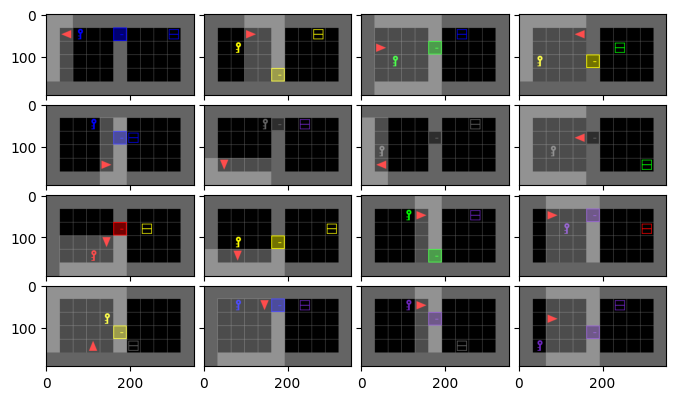

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
obs = vec_env.reset()

im_list = []
for e in vec_env.envs:
    #print(type(e.render('rgb_array')))
    #e.reset()
    im_list.append(e.render('rgb_array'))

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

Define hyperparameters

In [5]:
learning_rate = 0.0007 # for RMSProp
#learning_rate = 0.0001 # for Adam
n_steps = 128
batch_size = 256
ent_coef = 0.01
n_epochs = 4
gae_lambda = 0.99
#target_kl = 0.02
target_kl = None
#policy_kwargs = dict(activation_fn=torch.nn.ReLU,net_arch=nn_layers)

experiment = "_".join([env_id, "PPO", "RMSprop"])
print(experiment)

MiniGrid-DoorKey-6x6-v0_PPO_RMSprop


Create the model and define the Tensorboard log directory

In [6]:
tensorboard_log = "./tmp/log/"
os.makedirs(tensorboard_log, exist_ok=True)
# Reset the environment
vec_env.reset()

# create the model
model = PPO('MlpPolicy', env=vec_env, learning_rate=learning_rate, batch_size=batch_size, ent_coef=ent_coef, n_epochs=n_epochs, n_steps=n_steps, tensorboard_log=tensorboard_log,  policy_kwargs={'optimizer_class':torch.optim.RMSprop}, gae_lambda=gae_lambda, target_kl=target_kl, verbose=1)

Using cpu device


Define the callback for the model evaluation while training

In [8]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create eval environment
env = monitor_eval_env(env_id)
# Reset the environment
env.reset();
#For evaluating the performance of the agent periodically and logging the results.
#callback = EvalCallback(env, log_path = log_dir, deterministic=True)
# Stop training when the model reaches the reward threshold
eval_env = env

callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.92, verbose=1)
#stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, n_eval_episodes=10, callback_on_new_best=callback_on_best, eval_freq=1000, verbose=1)

Train the model

In [9]:
total_timesteps = 500000
log_interval = 1
#tb_log_name = env_id
tb_log_name = experiment

model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name,
            callback=eval_callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.
print('Final time_steps:', model.num_timesteps)

Logging to ./tmp/log/MiniGrid-DoorKey-6x6-v0_PPO_RMSprop_1
-----------------------------
| time/              |      |
|    fps             | 2208 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 244         |
|    ep_rew_mean          | 0.389       |
| time/                   |             |
|    fps                  | 1992        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019775392 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | -5.8        |
|    learning_rate        | 0.0007      |
|    loss                 | -0.0124     |
|    n_updates   

Evaluate teh model

Mean reward: 0.9431000000000002 +/- 0.14


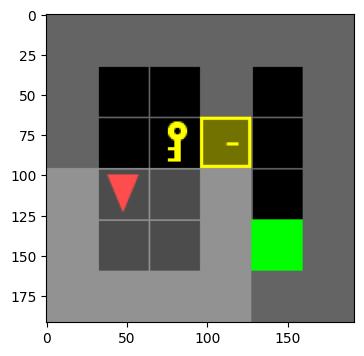

In [11]:
# We create a separate environment for evaluation
eval_env = monitor_eval_env(env_id, seed=3)

eval_env.reset()
before_img = eval_env.render('rgb_array')
plt.figure(figsize=(4., 4.))
plt.imshow(before_img);

# Evaluate the trained model over 100 episodes
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Define hyperparameters (Adam test)

In [4]:
#learning_rate = 0.0007 # for RMSProp
learning_rate = 2.5e-4 # for Adam
n_steps = 128
batch_size = 256
ent_coef = 0.01
n_epochs = 4
gae_lambda = 0.95
#target_kl = 0.02
target_kl = None
#policy_kwargs = dict(activation_fn=torch.nn.ReLU,net_arch=nn_layers)

experiment = "_".join([env_id, "PPO", "Adam"])
print(experiment)

MiniGrid-DoorKey-6x6-v0_PPO_Adam


Create the model and define the Tensorboard log directory

In [5]:
tensorboard_log = "./tmp/log/"
os.makedirs(tensorboard_log, exist_ok=True)
# Reset the environment
vec_env.reset()

# create the model
model = PPO('MlpPolicy', env=vec_env, learning_rate=learning_rate, batch_size=batch_size, ent_coef=ent_coef, n_epochs=n_epochs, n_steps=n_steps, tensorboard_log=tensorboard_log,  policy_kwargs={'optimizer_class':torch.optim.Adam}, gae_lambda=gae_lambda, target_kl=target_kl, verbose=1)

Using cpu device


Define the callback for the model evaluation while training

In [7]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create eval environment
env = monitor_eval_env(env_id)
# Reset the environment
env.reset();
#For evaluating the performance of the agent periodically and logging the results.
#callback = EvalCallback(env, log_path = log_dir, deterministic=True)
# Stop training when the model reaches the reward threshold
eval_env = env

callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.92, verbose=1)
#stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
#eval_callback = EvalCallback(eval_env, log_path=log_dir, n_eval_episodes=10, callback_on_new_best=callback_on_best, eval_freq=1000, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, n_eval_episodes=10, eval_freq=1000, verbose=1)

Train the model

In [8]:
total_timesteps = 500000
log_interval = 10
#tb_log_name = env_id
tb_log_name = experiment

model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name,
            callback=eval_callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.
print('Final time_steps:', model.num_timesteps)

Logging to ./tmp/log/MiniGrid-DoorKey-6x6-v0_PPO_Adam_1
Eval num_timesteps=16000, episode_reward=0.00 +/- 0.00
Episode length: 360.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 360          |
|    mean_reward          | 0            |
| time/                   |              |
|    total_timesteps      | 16000        |
| train/                  |              |
|    approx_kl            | 0.0009163605 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | -3.23        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0231      |
|    n_updates            | 28           |
|    policy_gradient_loss | -0.00178     |
|    value_loss           | 0.000416     |
------------------------------------------
New best mean reward!
------------------------------------------
| rollout/        

Evaluate teh model

Mean reward: 0.96745 +/- 0.01


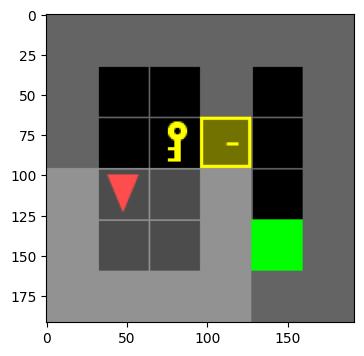

In [9]:
# We create a separate environment for evaluation
eval_env = monitor_eval_env(env_id, seed=3)

eval_env.reset()
before_img = eval_env.render('rgb_array')
plt.figure(figsize=(4., 4.))
plt.imshow(before_img);

# Evaluate the trained model over 100 episodes
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')